# 1. Set up Directories

In [1]:
import os
import pathlib
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

# When running the model with conv2d
# UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
# it is because the cnDNN version you installed is not compatible with the cuDNN version that compiled in tensorflow. -> Let conda or pip automatically choose the right version of tensorflow and cudnn.
# or run out of graphics card RAM -> must set limit for GPU RAM. Splitting into 2 logical GPU with different RAM limit. By default, Tensorflow will use on the logical GPU: 0, the GPU: 1 will be used for training generator and discriminator models.

# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     tf.config.experimental.set_memory_growth(device, True)


# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
# https://leimao.github.io/blog/TensorFlow-cuDNN-Failure/
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*0.4),
#          tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5.45) # for Training
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5) # for Testing
        ])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 2 Logical GPUs


In [2]:
train_15fps_dir = os.path.join(*['data', 'REDS_VTSR', 'train', 'train_15fps'])
# print(train_15fps_dir)

train_30fps_dir = os.path.join(*['data', 'REDS_VTSR', 'train', 'train_30fps'])
# print(train_30fps_dir)

train_60fps_dir = os.path.join(*['data', 'REDS_VTSR', 'train', 'train_60fps'])
# print(train_60fps_dir)

val_15fps_dir = os.path.join(*['data', 'REDS_VTSR', 'val', 'val_15fps'])
# print(val_15fps_dir)

val_30fps_dir = os.path.join(*['data', 'REDS_VTSR', 'val', 'val_30fps'])
# print(val_30fps_dir)

val_60fps_dir = os.path.join(*['data', 'REDS_VTSR', 'val', 'val_60fps'])
# print(val_60fps_dir)

test_15fps_dir = os.path.join(*['data', 'REDS_VTSR', 'test', 'test_15fps'])
# print(test_15fps_dir)

In [3]:
train_15fps_dir = [os.path.join(train_15fps_dir, p) for p in os.listdir(train_15fps_dir)]
# print('Train 15fps', train_15fps_dir[:2])

train_30fps_dir = [os.path.join(train_30fps_dir, p) for p in os.listdir(train_30fps_dir)]
# print('Train 30fps', train_30fps_dir[:2])

train_60fps_dir = [os.path.join(train_60fps_dir, p) for p in os.listdir(train_60fps_dir)]
# print('Train 60fps', train_60fps_dir[:2])

val_15fps_dir = [os.path.join(val_15fps_dir, p) for p in os.listdir(val_15fps_dir)]
# print('Val 15fps', val_15fps_dir[:2])

val_30fps_dir = [os.path.join(val_30fps_dir, p) for p in os.listdir(val_30fps_dir)]
# print('Val 30fps', val_30fps_dir[:2])

val_60fps_dir = [os.path.join(val_60fps_dir, p) for p in os.listdir(val_60fps_dir)]
# print('Val 60fps', val_60fps_dir[:2])

test_15fps_dir = [os.path.join(test_15fps_dir, p) for p in os.listdir(test_15fps_dir)]
# print('Val 15fps', test_15fps_dir[:2])

In [4]:

# print([len(os.listdir(i)) for i in train_30fps_dir])

## 1.1. None Images
in 30 fps and 60 fps folders

In [5]:
# image = cv2.imread(os.path.join(train_30fps_dir[0], '00000012.png'))
# print(image)
# print(os.path.getsize(os.path.join(train_30fps_dir[0], '00000012.png')))

### 1.1.1. Delete None Images

In [6]:
# Only need to run one.
# count = 0

# for folder in [train_30fps_dir, train_60fps_dir, val_30fps_dir, val_60fps_dir]:
#     for paths in folder:
#         paths = pathlib.Path(paths)

#         for p in paths.glob('*'):

#             if cv2.imread(str(p)) is None:
#                 os.remove(str(p))
#                 count+=1
# print(f'Deleted {count} files')
# Deleted 35809 files

## 1.2. Randomize Videos Paths

In [7]:
# [train_30fps_dir, train_60fps_dir, val_30fps_dir, val_60fps_dir]
import random
random.shuffle(train_30fps_dir) # make the training dataset random
random.shuffle(train_60fps_dir) # make the training dataset random

## 1.3. Get Image Paths

In [8]:
# test: all frames of 1 video as 1 element.
# Failed due to unable to flatten tensor objects

# image_30fps_paths = []
# for video_path in train_30fps_dir:
#     image_30fps_paths.append([os.path.join(video_path, x) for x in os.listdir(video_path)])

# output format: [[image1.png, image2.png,...], [image1.png, image2.png,...],...]

In [9]:
train_image_30fps_paths = []
for video_path in train_30fps_dir:
    for x in os.listdir(video_path):
        train_image_30fps_paths.append(os.path.join(video_path, x))

# output format: [image1.png, image2.png,...]

In [10]:
val_image_30fps_paths = []
for video_path in val_30fps_dir:
    for x in os.listdir(video_path):
        val_image_30fps_paths.append(os.path.join(video_path, x))

# output format: [image1.png, image2.png,...]

In [11]:
test_image_15fps_paths = []
for video_path in test_15fps_dir:
    for x in os.listdir(video_path):
        test_image_15fps_paths.append(os.path.join(video_path, x))

# output format: [image1.png, image2.png,...]

# 2. Loading Data

## 2.1. Train Dataset Pipeline

In [12]:
# # test: all frames of 1 video as 1 element.
# # Failed due to unable to flatten tensor objects

# def reverse(image_paths):
#     """
#     Function that randomly reverse frames sequence in 1 video.
#     1 video can only have 2 states: reversed or not reversed.
#     Args:
#         image_paths: Tensor object, list, tuple. The list of paths to frames in the video.
#     Returns:
#         image_paths: The list of paths to frames in the video with reversed order.
#     """
#     method_list = ['reverse', None]
#     reverse_method = random.choice(method_list)
    
#     if reverse_method == 'reverse':
#         image_paths = tf.reverse(image_paths, axis=[0])
        
#     return image_paths

# def flip_method(images):
#     """
#     Function that flip horizontally/vertically all frames in 1 video.
#     Args:
#         images: Tensor object, list, tuple. The list of frames in the video.
#     Returns:
#         images: Tensor object, list, tuple. The list of (unchanged) frames in the video.
#         method: flip or not
#     """ 
# #     flip the image randomly
#     method_list = ['horizontal', 'vertical', None]
#     flip_method = random.choice(method_list)
#     flip_method = np.array([flip_method] * 45)
#     images = tf.squeeze(images)
    
#     return images, flip_method

# image = tf.io.read_file(i)
#         image = tf.image.decode_jpeg(image, channels=3)
#         image = tf.image.convert_image_dtype(image, tf.float32)

# def parse_image(image_paths):
#     """
#     Function that loads the images given the path.
#     Args:
#         image_paths: Tensor object, list, tuple. The list of paths to frames in the video.
#     Returns:
#         image_paths: A tf tensor of the loaded frames.
#     """
#     parsed_images = []
#     print(image_paths)
#     for i in image_paths[0]:
#         print(i)
#         image = tf.io.read_file(i)
#         image = tf.image.decode_jpeg(image, channels=3)
#         image = tf.image.convert_image_dtype(image, tf.float32)
#         print(image)
#         try:
#             parsed_images = tf.stack([parsed_images, image])
#         except:
#             parsed_images = image
# #         parsed_images.append(image)

#     return [parsed_images]



# def high_low_res_pairs(high_res, scale=4):
#     """
#     Function that generates a low resolution image given the 
#     high resolution image.
#     Args:
#         high_res: A tf tensor of the high res image.
#         scale: Int, The downsampling factor, default is 4x.
#     Returns:
#         low_res: A tf tensor of the low res image.
#         high_res: A tf tensor of the high res image.
#     """
#     method_list = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
#     downsampling_method = random.choice(method_list)
    
#     low_res = tf.image.resize(high_res, 
#                               [high_res.shape[0] // scale, high_res.shape[1] // scale],
#                               preserve_aspect_ratio=True,
#                               method=downsampling_method)    
#     return low_res, high_res

# def rescale(low_res, high_res):
#     """
#     Function that rescales the pixel values of high_res to the -1 to 1 range.
#     For use with the generator output tanh function.
#     Args:
#         low_res: The tf tensor of the low res image.
#         high_res: The tf tensor of the high res image.
#     Returns:
#         low_res: The tf tensor of the low res image, rescaled.
#         high_res: The tf tensor of the high res image, rescaled.
#     """
#     high_res = high_res * 2.0 - 1.0

#     return low_res, high_res

# def parse_video(video_path, image_paths):
#     """
#     Function that loads frames of the video in given path.
#     Args:
#         video_path: Tensor object that contains path to a video folder.
#     Predefined functions:
#         parse_image
#         high_low_res_pairs
#         rescale
#         reverse
#         flip
#     Returns:
#         low_res: A tf tensor of the low res image.
#         high_res: A tf tensor of the high res image.
#     """
#     low_res_images = []
#     high_res_images = []
    
#     print(video_path)
#     print(image_paths)
# #     print(tf.convert_to_tensor(video_path))
# #     return
# #     video_path format: Tensor("args_0:0", shape=(1,), dtype=string)
# # -> it makes: image_paths = [os.path.join(video_path, x) for x in os.listdir(video_path)] get error

# #     image_paths = [os.path.join(video_path, x) for x in os.listdir(video_path)]
    
#     for i in range(len(image_paths)):
#         image_paths[i] = reverse(image_paths[i])
    
#         for path_to_image in image_paths:

#     #         read image
#             image = parse_image(path_to_image)



#             image = flip(image, method=flip_method)

#     #         low/high res images
#             low_res, high_res = high_low_res_pairs(image, scale=4)
#             low_res, high_res = rescale(low_res, high_res)

#             low_res_images.append(low_res)
#             high_res_images.append(high_res)
    
#     return np.array(low_res_images), np.array(high_res_images)
# #     sample output: [(np.array[low_res_images], np.array[high_res_images]),
# #                     (np.array[low_res_images], np.array[high_res_images]),
# #                     ...]

# # result must be list with shape (1,)
    
    

In [13]:
hr_height = 360
hr_width = 640
scale = 4

lr_height = hr_height // scale
lr_width = hr_width // scale

In [14]:
# 1 image as 1 element

def reverse(ds):
    """
    Function that randomly reverse frames sequence in 1 video.
    Args:
        ds: A tf dataset.
    Returns:
        ds: A tf dataset with reversed frames sequence.
    """ 
#     reverse squence randomly
    method_list = ['reverse', None]
    reverse_method = random.choice(method_list)
    
    image_list = list(ds.as_numpy_iterator())

    if reverse_method == 'reverse':
        image_list.reverse()

    return tf.data.Dataset.from_tensor_slices(image_list)

def parse_image(image_path):
    """
    Function that loads the images given the path.
    Args:
        image_path: The paths to frames in the video.
    Returns:
        image: A tf tensor of the loaded frames.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    return image

def flip(ds):
    """
    Function that flip horizontally/vertically all images in 1 dataset.
    Args:
        ds: A tf dataset.
    Returns:
        ds: A tf dataset with flipped images.
    """ 
#     flip the image randomly
    method_list = ['horizontal', 'vertical', None]
    flip_method = random.choice(method_list)
    
    def flip_left_right(image):
        image = tf.image.flip_left_right(image)
        return image
    
    def flip_up_down(image):
        image = tf.image.flip_up_down(image)
        return image
    
    if flip_method == 'horizontal':
        ds = ds.map(flip_up_down, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    elif flip_method == 'vertical':
        ds = ds.map(flip_left_right, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
    return ds

def high_low_res_pairs(ds):
    """
    Function that generates a low resolution image given the high resolution image with random methods.
    Listed methods: ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
    Default downsampling factor is 4x.
    Args:
        ds: A tf dataset.
    Returns:
        ds: A tf dataset with low and high res images.
    """
    method_list = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
    downsampling_method = random.choice(method_list)
    
    def downsampling(high_res):
        """
        Function that generates a low resolution image given the high resolution image.
        Args:
            high_res: A tf tensor of the high res image.
        Returns:
            low_res: A tf tensor of the low res image.
            high_res: A tf tensor of the high res image.
        """
#         print(tf.shape(high_res)[0])
        low_res = tf.image.resize(high_res, 
                                  [lr_height, lr_width],
                                  preserve_aspect_ratio=True,
                                  method=downsampling_method)
    
        high_res = tf.image.resize(high_res, 
                                  [hr_height, hr_width],
                                  preserve_aspect_ratio=True,
                                  method=downsampling_method)
        return low_res, high_res
    
    ds = ds.map(downsampling, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return ds

def rescale(low_res, high_res):
    """
    Function that rescales the pixel values of high_res to the -1 to 1 range.
    For use with the generator output tanh function.
    Args:
        low_res: The tf tensor of the low res image.
        high_res: The tf tensor of the high res image.
    Returns:
        low_res: The tf tensor of the low res image, rescaled.
        high_res: The tf tensor of the high res image, rescaled.
    """
    high_res = high_res * 2.0 - 1.0

    return low_res, high_res

def dataset(image_paths, batch_size=2):
    """
    Returns a tf dataset object with specified mappings. No shuffle and No repeat.
    No shuffle because it will screw up the frame sequence.
    No repeat because training model will use a manual for loop.
    Args:
        image_paths: Str, Path to images.
        batch_size: Int, The number of elements in a batch returned by the dataset.
    Returns:
        dataset: A tf dataset object.
    """
    
    # Generate tf dataset from high res video paths.
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Prefetch the data for optimal GPU utilization.
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # apply: Applies a transformation function to the whole dataset as once. Good for functions with the same random arg.

    # randomly reverse frames sequence in 1 video
    dataset = dataset.apply(reverse)

    # image paths to tensor
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)

    # randomly flip all frames in 1 video
    dataset = dataset.apply(flip)

    # Generate low resolution by downsampling.
    dataset = dataset.apply(high_low_res_pairs)

    # Rescale the values in the input
    dataset = dataset.map(rescale, num_parallel_calls=AUTOTUNE)

    # Batch the input, drop remainder to get a defined batch size.
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)

    return dataset

In [15]:
# image_test = parse_image(os.path.join(train_30fps_dir[0], '00000012.png'))
# low, high = high_low_res_pairs(image_test, scale=4)

# f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))

# ax1.imshow(low)
# ax1.set_title('Low Res')

# ax2.imshow(high)
# ax2.set_title('High Res')

In [16]:
train_dataset = dataset(train_image_30fps_paths, batch_size=2)
# sample_train_dataset = dataset(train_image_30fps_paths[:180], batch_size=2)

In [17]:
# print(tf.io.read_file(dataset.take(1)[0][0][0]))

# f, ax = plt.subplots(4, 2, figsize=(40, 50))
# i=0
# for f in dataset.take(2):
#     for c in f[:2]:
#         ax[i][0].imshow(tf.squeeze(c[0]))
#         ax[i][1].imshow(tf.squeeze(c[1]))

#         i+=1

## 2.2. Validation + Test Dataset Pipeline

In [18]:
# 1 image as 1 element
def val_low_res(ds):
    """
    Function that generates a low resolution image given the high resolution image with random methods.
    Listed methods: ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
    Default downsampling factor is 4x.
    Args:
        ds: A tf dataset.
    Returns:
        ds: A tf dataset with low and high res images.
    """
    method_list = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
    downsampling_method = random.choice(method_list)
    
    def downsampling(high_res):
        """
        Function that generates a low resolution image given the high resolution image.
        Args:
            high_res: A tf tensor of the high res image.
        Returns:
            low_res: A tf tensor of the low res image.
            high_res: A tf tensor of the high res image.
        """
#         print(tf.shape(high_res)[0])
        low_res = tf.image.resize(high_res, 
                                  [lr_height, lr_width],
                                  preserve_aspect_ratio=True,
                                  method=downsampling_method)   
        return low_res
    
    ds = ds.map(downsampling, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    return ds


def val_dataset(image_paths, batch_size=2):
    """
    Returns a tf dataset object with specified mappings. No shuffle and repeat.
    Args:
        image_paths: Str, Path to images.
        batch_size: Int, The number of elements in a batch returned by the dataset.
    Returns:
        dataset: A tf dataset object.
    """
    
    # Generate tf dataset from high res video paths.
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)

    # Prefetch the data for optimal GPU utilization.
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    # image paths to tensor
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    
    # Generate low resolution by downsampling.
    dataset = dataset.apply(val_low_res)

    # Batch the input, drop remainder to get a defined batch size.
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(AUTOTUNE)

    return dataset

In [19]:
val_dataset = val_dataset(val_image_30fps_paths, batch_size=2)
# sample_val_dataset = val_dataset(val_image_30fps_paths[:90], batch_size=2)

#  test_dataset = val_dataset(test_image_15fps_paths)

# 3. Models

## 3.1. Generator Model

In [20]:
hr_shape = (hr_height, hr_width, 3)
lr_shape = (lr_height, lr_width, 3)

In [21]:
# We use a pre-trained VGG19 model to extract image features from the high resolution
# and the generated high resolution images and minimize the mse between them
# Get the vgg network. Extract features from Block 5, last convolution, exclude layer block5_pool (MaxPooling2D)
vgg = tf.keras.applications.VGG19(weights="imagenet", input_shape=hr_shape, include_top=False)
vgg.trainable = False

# Create model and compile
vgg_model = tf.keras.models.Model(inputs=vgg.input, outputs=vgg.get_layer("block5_conv4").output)
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 360, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 360, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 180, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 180, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 180, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 90, 160, 128)      0     

In [22]:
@tf.function
def content_loss(hr, sr):
    """
    Returns Mean Square Error of VGG19 feature extracted original image (y) and VGG19 feature extracted generated image (y_hat).
    Args:
        hr: A tf tensor of original image (y)
        sr: A tf tensor of generated image (y_hat)
    Returns:
        mse: Mean Square Error.
    """
    sr = tf.keras.applications.vgg19.preprocess_input(((sr + 1.0) * 255) / 2.0)
    hr = tf.keras.applications.vgg19.preprocess_input(((hr + 1.0) * 255) / 2.0)
    sr_features = vgg_model(sr) / 12.75
    hr_features = vgg_model(hr) / 12.75
    mse = tf.keras.losses.MeanSquaredError()(hr_features, sr_features)
    return mse

In [23]:
def build_generator():
    """Build the generator that will do the Super Resolution task.
    Based on the Mobilenet design. Idea from Galteri et al."""

    def make_divisible(v, divisor, min_value=None):
            if min_value is None:
                min_value = divisor
            new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
            # Make sure that round down does not go down by more than 10%.
            if new_v < 0.9 * v:
                new_v += divisor
            return new_v

    def residual_block(inputs, filters, block_id, expansion=6, stride=1, alpha=1.0):
        """Inverted Residual block that uses depth wise convolutions for parameter efficiency.
        Args:
            inputs: The input feature map.
            filters: Number of filters in each convolution in the block.
            block_id: An integer specifier for the id of the block in the graph.
            expansion: Channel expansion factor.
            stride: The stride of the convolution.
            alpha: Depth expansion factor.
        Returns:
            x: The output of the inverted residual block.
        """
        channel_axis = 1 if keras.backend.image_data_format() == 'channels_first' else -1

        in_channels = keras.backend.int_shape(inputs)[channel_axis]
        pointwise_conv_filters = int(filters * alpha)
        pointwise_filters = make_divisible(pointwise_conv_filters, 8)
        x = inputs
        prefix = 'block_{}_'.format(block_id)

        if block_id:
            # Expand
            x = keras.layers.Conv2D(expansion * in_channels, kernel_size=1, padding='same', use_bias=True, activation=None,
                                    name=prefix + 'expand')(x)
            x = keras.layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999,
                                                name=prefix + 'expand_BN')(x)
            x = keras.layers.Activation('relu', name=prefix + 'expand_relu')(x)
        else:
            prefix = 'expanded_conv_'

        # Depthwise
        x = keras.layers.DepthwiseConv2D(kernel_size=3, strides=stride, activation=None, use_bias=True, padding='same' if stride == 1 else 'valid',
                                         name=prefix + 'depthwise')(x)
        x = keras.layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999,
                                            name=prefix + 'depthwise_BN')(x)

        x = keras.layers.Activation('relu', name=prefix + 'depthwise_relu')(x)

        # Project
        x = keras.layers.Conv2D(pointwise_filters, kernel_size=1, padding='same', use_bias=True, activation=None,
                                name=prefix + 'project')(x)
        x = keras.layers.BatchNormalization(axis=channel_axis, epsilon=1e-3, momentum=0.999,
                                            name=prefix + 'project_BN')(x)

        if in_channels == pointwise_filters and stride == 1:
            return keras.layers.Add(name=prefix + 'add')([inputs, x])
        return x

    def deconv2d(layer_input):
        """Upsampling layer to increase height and width of the input.
        Uses Conv2DTranspose.
        Args:
            layer_input: The input tensor to upsample.
        Returns:
            u: Upsampled input by a factor of 2.
        """
        u = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME")(layer_input)
#         u = keras.layers.UpSampling2D(size=2, interpolation='bilinear')(layer_input)
        
        # Number of filters in the first layer. Realtime Image Enhancement GAN Galteri et al.
#         u = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(u)
        u = keras.layers.PReLU(shared_axes=[1, 2])(u)
        return u

    # Low resolution image input
    img_lr = keras.Input(shape=lr_shape)

    # Pre-residual block
    c1 = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(img_lr)
    c1 = keras.layers.BatchNormalization()(c1)
    c1 = keras.layers.PReLU(shared_axes=[1, 2])(c1)

    # Propogate through residual blocks
    r = residual_block(c1, 32, 0)
    
    # Number of inverted residual blocks in the mobilenet generator    
    for idx in range(1, 6):
        r = residual_block(r, 32, idx)

    # Post-residual block
    c2 = keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(r)
    c2 = keras.layers.BatchNormalization()(c2)
    c2 = keras.layers.Add()([c2, c1])

    # Upsampling
    u1 = deconv2d(c2)
    u2 = deconv2d(u1)

    # Generate high resolution output
    gen_hr = keras.layers.Conv2D(3, kernel_size=3, strides=1, padding='same', activation='tanh')(u2)

    return keras.models.Model(img_lr, gen_hr)

In [25]:
# use 
gen_model = build_generator()

# # Generator loss
# content_loss = content_loss(y, fake_hr)
# adv_loss = 1e-3 * tf.keras.losses.BinaryCrossentropy()(valid, fake_prediction)
# mse_loss = tf.keras.losses.MeanSquaredError()(y, fake_hr)
# perceptual_loss = content_loss + adv_loss + mse_loss
        
# gen_model.compile(optimizer='Adam',
#                   loss=tf.keras.losses.MeanSquaredError(),
#                   metrics=['accuracy'])

gen_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 90, 160, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 90, 160, 32)  896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 90, 160, 32)  128         conv2d_3[0][0]                   
__________________________________________________________________________________________________
p_re_lu_3 (PReLU)               (None, 90, 160, 32)  32          batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [25]:
# Testing if gen_model can run or not

# gen_predict_val = gen_model.predict(val_dataset)
# gen_predict_val.shape
# gen_predict_val = tf.cast(255*(gen_predict_val + 1)/2, tf.uint8)

# UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
# it is because the cnDNN version you installed is not compatible with the cuDNN version that compiled in tensorflow.

## 3.2. Discriminator Model

In [26]:
def build_discriminator():
    """Builds a discriminator network based on the SRGAN design."""

    def d_block(layer_input, filters, strides=1, bn=True):
        """Discriminator layer block.
        Args:
            layer_input: Input feature map for the convolutional block.
            filters: Number of filters in the convolution.
            strides: The stride of the convolution.
            bn: Whether to use batch norm or not.
        """
        d = keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
        if bn:
            d = keras.layers.BatchNormalization(momentum=0.8)(d)
        d = keras.layers.LeakyReLU(alpha=0.2)(d)

        return d

    # Input img
    d0 = keras.layers.Input(shape=hr_shape)

    d1 = d_block(d0, 32, bn=False)
    d2 = d_block(d1, 32, strides=2)
    d3 = d_block(d2, 32)
    d4 = d_block(d3, 32, strides=2)
    d5 = d_block(d4, 64)
    d6 = d_block(d5, 64, strides=2)
    d7 = d_block(d6, 64)
    d8 = d_block(d7, 64, strides=2)

    validity = keras.layers.Conv2D(1, kernel_size=1, strides=1, activation='sigmoid', padding='same')(d8)

    return keras.models.Model(d0, validity)

In [27]:
disc_model = build_discriminator()
disc_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 360, 640, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 360, 640, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 360, 640, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 320, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 180, 320, 32)      128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 180, 320, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 320, 32)      9248

## 3.3. Optimizers

In [28]:
# Define a learning rate decay schedule.
lr = 1e-4

gen_schedule = keras.optimizers.schedules.ExponentialDecay(
    lr,
    decay_steps=100000,
    decay_rate=0.1,
    staircase=True
)

disc_schedule = keras.optimizers.schedules.ExponentialDecay(
    lr * 5,  # TTUR - Two Time Scale Updates
    decay_steps=100000,
    decay_rate=0.1,
    staircase=True
)

gen_optimizer = keras.optimizers.Adam(learning_rate=gen_schedule)
disc_optimizer = keras.optimizers.Adam(learning_rate=disc_schedule)

# 4. Training

In [29]:
height_patch = 23
# int(hr_height / 2 ** 4)

width_patch = 40
# int(hr_width / 2 ** 4)

disc_patch = (height_patch, width_patch, 1)
# disc_patch

pretrain_iteration = 1
train_iteration = 1

In [30]:
@tf.function
def pretrain_step(gen_model, x, y):
    """
    Single step of generator pre-training.
    Args:
        gen_model: A compiled generator model.
        x: The low resolution image tensor.
        y: The high resolution image tensor.
    """
    with tf.GradientTape() as tape:
        fake_hr = gen_model(x)
        loss_mse = tf.keras.losses.MeanSquaredError()(y, fake_hr)

    grads = tape.gradient(loss_mse, gen_model.trainable_variables)
    gen_optimizer.apply_gradients(zip(grads, gen_model.trainable_variables))

    return loss_mse


def pretrain_generator(gen_model, dataset, writer):
    """Function that pretrains the generator slightly, to avoid local minima.
    Args:
        gen_model: A compiled generator model.
        dataset: A tf dataset object of low and high res images to pretrain over.
        writer: A summary writer object.
    Returns:
        None
    """
    global pretrain_iteration
    
    with writer.as_default():
        for _ in range(1):
            for x, y in dataset:
                loss = pretrain_step(gen_model, x, y)
                if pretrain_iteration % 20 == 0:
                    print(f'Pretrain Step: {pretrain_iteration}, Pretrain MSE Loss: {loss}')
                    tf.summary.scalar('MSE Loss', loss, step=tf.cast(pretrain_iteration, tf.int64))
                    writer.flush()
                pretrain_iteration += 1

@tf.function
def train_step(gen_model, disc_model, x, y):
    """Single train step function for the SRGAN.
    Args:
        gen_model: A compiled generator model.
        disc_model: A compiled discriminator model.
        x: The low resolution input image.
        y: The desired high resolution output image.
    Returns:
        disc_loss: The mean loss of the discriminator.
        adv_loss: The Binary Crossentropy loss between real label and predicted label.
        cont_loss: The Mean Square Error of VGG19 feature extracted original image (y) and VGG19 feature extractedgenerated image (y_hat).
        mse_loss: The Mean Square Error of original image (y) and generated image (y_hat).
    """
    # Label smoothing for better gradient flow
    valid = tf.ones((x.shape[0],) + disc_patch)
    fake = tf.zeros((x.shape[0],) + disc_patch)
#     print('label')
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # From low res. image generate high res. version
        fake_hr = gen_model(x)
#         print('gen_model')

        # Train the discriminators (original images = real / generated = Fake)
        valid_prediction = disc_model(y)
        fake_prediction = disc_model(fake_hr)
#         print('disc_model')
        # Generator loss
        cont_loss = content_loss(y, fake_hr)
        adv_loss = 1e-3 * tf.keras.losses.BinaryCrossentropy()(valid, fake_prediction)
        mse_loss = tf.keras.losses.MeanSquaredError()(y, fake_hr)
        perceptual_loss = cont_loss + adv_loss + mse_loss

        # Discriminator loss
        valid_loss = tf.keras.losses.BinaryCrossentropy()(valid, valid_prediction)
        fake_loss = tf.keras.losses.BinaryCrossentropy()(fake, fake_prediction)
        disc_loss = tf.add(valid_loss, fake_loss)

#         print('finish gradient')
        
    # Backprop on Generator
    gen_grads = gen_tape.gradient(perceptual_loss, gen_model.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_variables))

    # Backprop on Discriminator
    disc_grads = disc_tape.gradient(disc_loss, disc_model.trainable_variables)
    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_variables))
#     print('optimizer')
    
    return disc_loss, adv_loss, cont_loss, mse_loss


def train(gen_model, disc_model, dataset, writer, log_iter=200):
    """
    Function that defines a single training step for the SR-GAN.
    Args:
        gen_model: A compiled generator model.
        disc_model: A compiled discriminator model.
        dataset: A tf data object that contains low and high res images.
        log_iter: Number of iterations after which to add logs in 
                  tensorboard.
        writer: Summary writer
    """
    global train_iteration
    
    with writer.as_default():
        # Iterate over dataset
        for x, y in dataset:
            disc_loss, adv_loss, cont_loss, mse_loss = train_step(gen_model, disc_model, x, y)
#             print(train_iteration)
            # Log tensorboard summaries if log iteration is reached.
            if train_iteration % log_iter == 0:
                print(f'Train Step: {train_iteration}, Adversarial Loss: {adv_loss}, Content Loss: {cont_loss}, MSE Loss: {mse_loss}, Discriminator Loss: {disc_loss}')
                
                tf.summary.scalar('Adversarial Loss', adv_loss, step=train_iteration)
                tf.summary.scalar('Content Loss', cont_loss, step=train_iteration)
                tf.summary.scalar('MSE Loss', mse_loss, step=train_iteration)
                tf.summary.scalar('Discriminator Loss', disc_loss, step=train_iteration)
                tf.summary.image('Low Res', tf.cast(255 * x, tf.uint8), step=train_iteration)
                tf.summary.image('High Res', tf.cast(255 * (y + 1.0) / 2.0, tf.uint8), step=train_iteration)
                tf.summary.image('Generated', tf.cast(255 * (gen_model.predict(x) + 1.0) / 2.0, tf.uint8), step=train_iteration)
                gen_model.save('models/generator_2.h5')
                disc_model.save('models/discriminator_2.h5')
                writer.flush()
            train_iteration += 1

In [31]:
# utilize the multiple GPUs
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
    
with tf.device('/device:GPU:1'):
    # Define the directory for saving pretrainig loss tensorboard summary.
    pretrain_summary_writer = tf.summary.create_file_writer('logs_2/pretrain')

    # Run pre-training.
#     sample_train_dataset
#     train_dataset
    pretrain_generator(gen_model, train_dataset, pretrain_summary_writer)
    gen_model.save('models/generator_2.h5')
    
    # Define the directory for saving the SRGAN training tensorbaord summary.
    train_summary_writer = tf.summary.create_file_writer('logs_2/train')

    epochs = 2

    # Run training.
    for _ in range(epochs):
        print('===================')
        print(f'Epoch: {_}\n')
        
        train(gen_model, disc_model, train_dataset, train_summary_writer, log_iter=200)

# ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
# ```
# with strategy.scope():
#     loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
# ....
#     loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)

Pretrain Step: 20, Pretrain MSE Loss: 0.2115798145532608
Pretrain Step: 40, Pretrain MSE Loss: 0.11454479396343231
Pretrain Step: 60, Pretrain MSE Loss: 0.06302903592586517
Pretrain Step: 80, Pretrain MSE Loss: 0.014448248781263828
Train Step: 20, Adversarial Loss: 0.001265631290152669, Content Loss: 0.19229301810264587, MSE Loss: 0.06551827490329742, Discriminator Loss: 0.9399911165237427
Train Step: 40, Adversarial Loss: 0.0007144010160118341, Content Loss: 0.1103486493229866, MSE Loss: 0.013762152753770351, Discriminator Loss: 1.3704360723495483
Train Step: 60, Adversarial Loss: 0.0006632150616496801, Content Loss: 0.17036882042884827, MSE Loss: 0.0493137426674366, Discriminator Loss: 1.1672842502593994
Train Step: 80, Adversarial Loss: 0.0007247310131788254, Content Loss: 0.06420890986919403, MSE Loss: 0.010135100223124027, Discriminator Loss: 1.2994441986083984
Train Step: 20, Adversarial Loss: 0.0009622846264392138, Content Loss: 0.1769925355911255, MSE Loss: 0.0484156496822834, 

In [20]:
with tf.device('/device:GPU:1'):

    # Recreate the exact same model, including its weights and the optimizer
    gen_model = tf.keras.models.load_model('models/generator.h5')

    # Show the model architecture
#     gen_model.summary()
    val_pred = gen_model.predict(sample_val_dataset)
    val_pred = tf.cast(255 * (val_pred + 1.0) / 2.0, tf.uint8)

for i in sample_val_dataset.take(1):
    test_val = i

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(50, 25))
ax1.imshow(val_pred[0])
ax2.imshow(test_val[0])


TypeError: __init__() got an unexpected keyword argument 'figisze'

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
%tensorboard --logdir ./logs_2/

Reusing TensorBoard on port 6006 (pid 14908), started 0:01:09 ago. (Use '!kill 14908' to kill it.)

In [2]:
gen_2

array([[[[ 58.531406 ,  52.203316 ,  51.926933 ],
         [ 43.835754 ,  41.612335 ,  34.43374  ],
         [ 37.664886 ,  38.16646  ,  29.089392 ],
         ...,
         [  9.827686 ,  10.615482 ,  10.052247 ],
         [ 12.116729 ,  12.83524  ,  10.5597925],
         [ 29.118462 ,  31.157827 ,  22.780272 ]],

        [[ 39.046112 ,  32.099022 ,  26.192352 ],
         [ 33.79917  ,  31.77362  ,  22.16772  ],
         [ 29.308405 ,  30.0673   ,  18.8297   ],
         ...,
         [ 12.0638895,  12.572226 ,   9.036371 ],
         [ 12.533392 ,  14.591179 ,   9.59485  ],
         [ 16.373816 ,  17.165556 ,  11.361315 ]],

        [[ 41.005787 ,  31.001032 ,  22.337893 ],
         [ 37.874725 ,  30.20056  ,  19.235662 ],
         [ 34.629093 ,  29.030138 ,  17.836288 ],
         ...,
         [ 11.917217 ,  11.075471 ,   8.22757  ],
         [ 10.672784 ,  11.9133415,   8.714779 ],
         [ 11.574042 ,  14.98879  ,   8.876195 ]],

        ...,

        [[132.01183  , 152.80626  , 17

1 Physical GPUs, 1 Logical GPUs
nearest


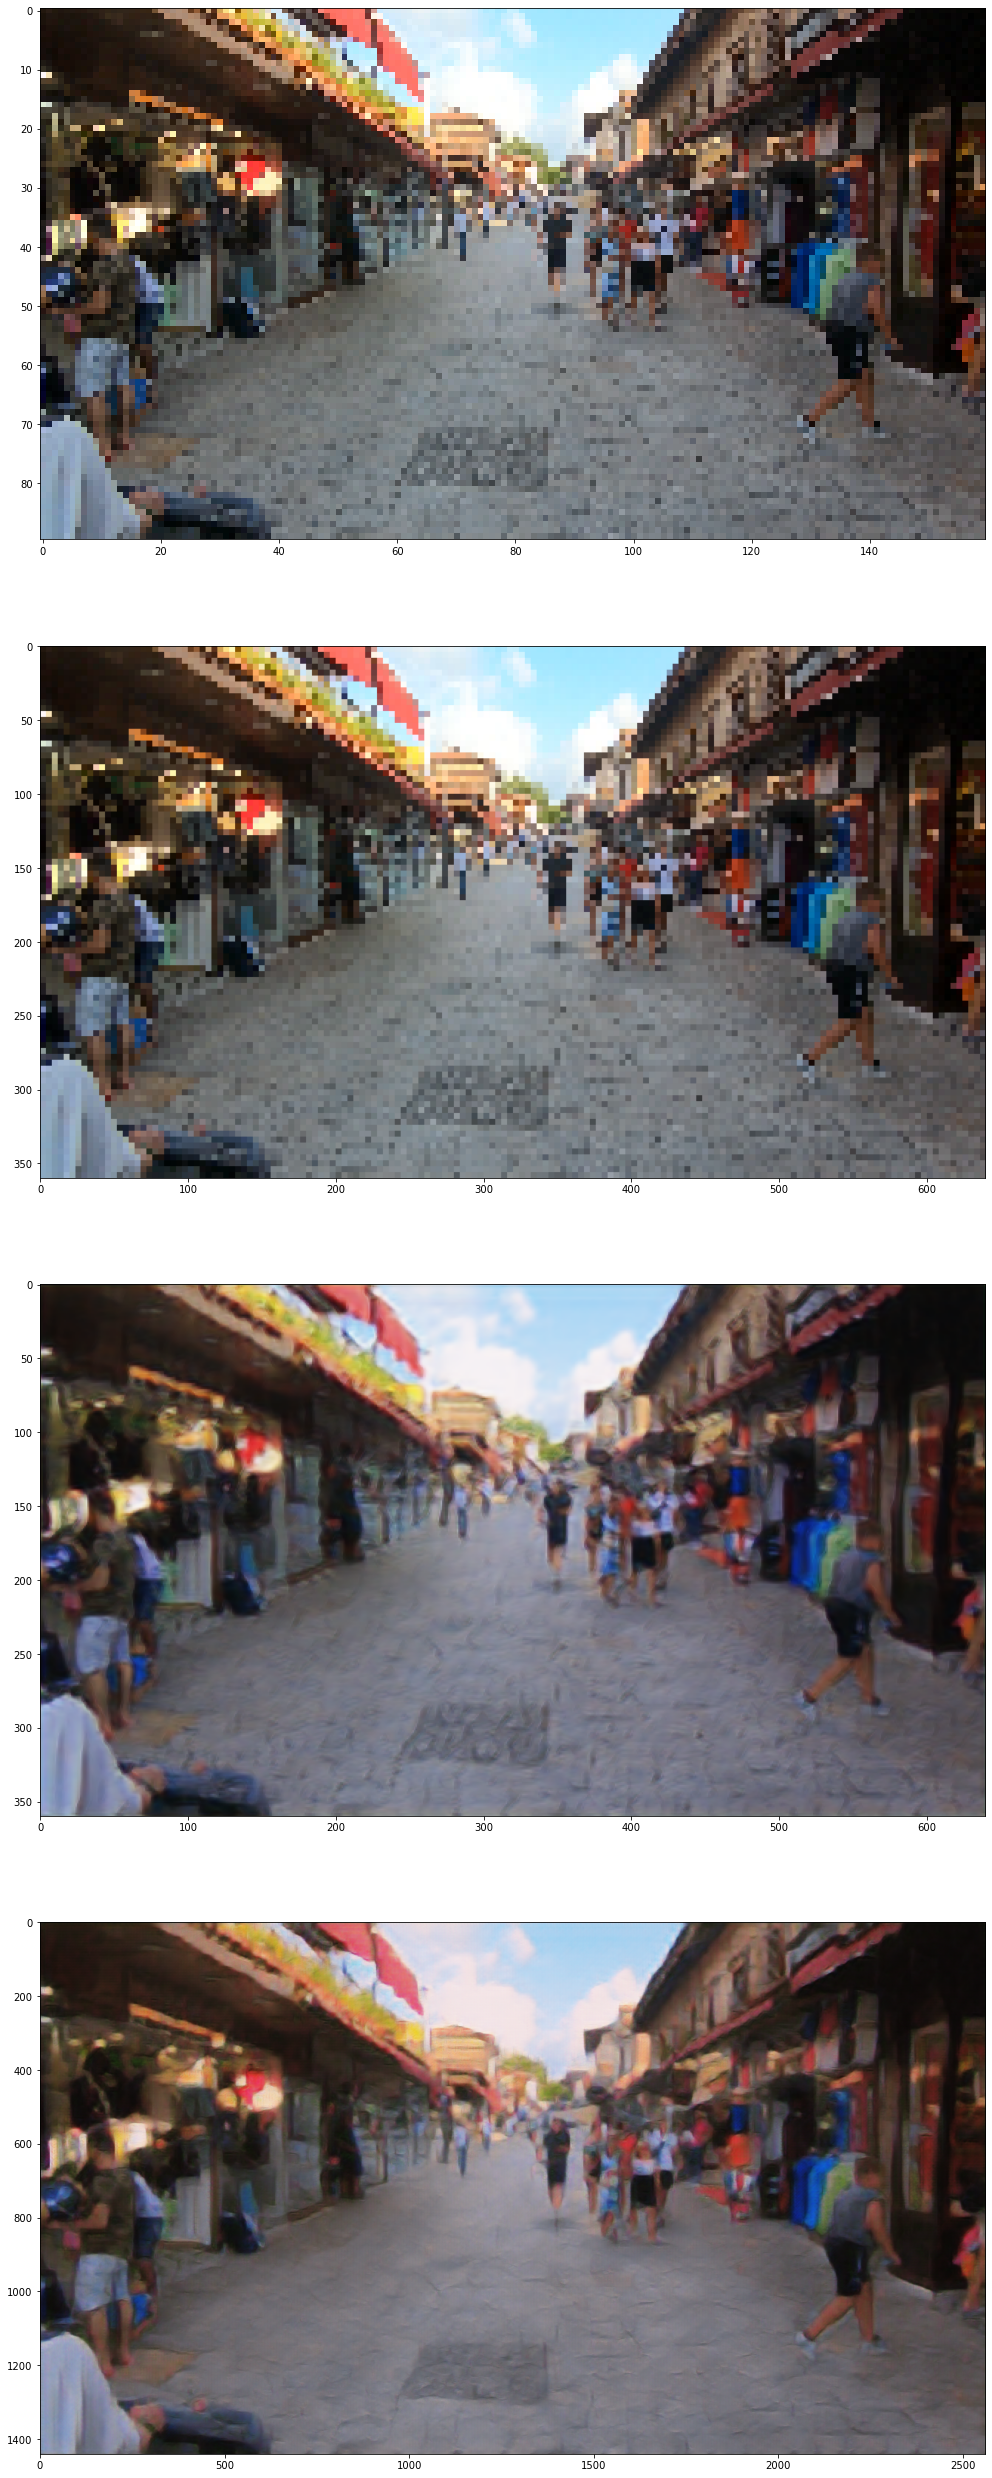

In [4]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    # Currently, memory growth needs to be the same across GPUs
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [
#          tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*1),
#          tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*5.45) # for Training
         tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4.5) # for Testing
        ])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

import matplotlib.pyplot as plt
import random


# for i in val_dataset.take(1):
#     image = i

# image = image[0]
    
image = tf.io.read_file('results\low_2.png')
image = tf.image.decode_jpeg(image, channels=3)

image_adj = tf.image.convert_image_dtype(image, tf.float32)

# image_adj = image_adj / 255.

image_adj = tf.expand_dims(image_adj, axis=0)

# with tf.device('/device:GPU:1'):

# Recreate the exact same model, including its weights and the optimizer
gen_model_1 = tf.keras.models.load_model('models/generator.h5')

gen_1 = gen_model_1.predict(image_adj)
gen_1 = tf.cast(255 * (gen_1 + 1.0) / 2.0, tf.uint8)

# Recreate the exact same model, including its weights and the optimizer
gen_model_2 = tf.keras.models.load_model('models/generator_2.h5')

# Define arbitrary spatial dims, and 3 channels.
inputs = tf.keras.Input((None, None, 3))

# Trace out the graph using the input:
outputs = gen_model_2(inputs)

# Override the model:
gen_model_2 = tf.keras.models.Model(inputs, outputs)

gen_2 = gen_model_2.predict(image_adj)
gen_2 = tf.cast(255 * (gen_2 + 1.0) / 2.0, tf.uint8)

gen_2 = tf.image.convert_image_dtype(gen_2, tf.float32)

gen_2 = gen_model_2.predict(gen_2)
gen_2 = tf.cast(255 * (gen_2 + 1.0) / 2.0, tf.uint8)

# image_high = tf.io.read_file('E:\CoderSchool_Final_Project\super_resolution_video\results\gen_1.png')
# image_high = tf.image.decode_jpeg(image_high, channels=3)

hr_height = 360
hr_width = 640

method_list = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
downsampling_method = random.choice(method_list)
print(downsampling_method)
high_res = tf.image.resize(image, 
                          [hr_height, hr_width],
                          preserve_aspect_ratio=True,
                          method=downsampling_method)

high_res = tf.cast(high_res, tf.uint8)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(80, 45))
ax1.imshow(image)
ax2.imshow(high_res)
ax3.imshow(gen_1[0])
ax4.imshow(gen_2[0])

In [7]:
method_list = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest', 'area', 'mitchellcubic']
downsampling_method = random.choice(method_list)
tf.image.resize(image_adj, 
                                  [lr_height, lr_width],
                                  preserve_aspect_ratio=True,
                                  method=downsampling_method) 

<tf.Tensor: shape=(1, 90, 160, 3), dtype=float32, numpy=
array([[[[ 34.,  23.,  14.],
         [ 42.,  29.,  21.],
         [ 34.,  25.,  13.],
         ...,
         [  6.,   6.,   4.],
         [  7.,   5.,   4.],
         [  2.,   5.,   3.]],

        [[ 27.,  18.,  10.],
         [ 32.,  22.,  17.],
         [ 32.,  23.,  15.],
         ...,
         [  0.,   1.,   1.],
         [  4.,   4.,   2.],
         [  5.,   5.,   3.]],

        [[ 27.,  18.,  11.],
         [ 33.,  21.,  14.],
         [ 33.,  19.,  13.],
         ...,
         [  2.,   1.,   3.],
         [  3.,   5.,   5.],
         [  8.,   8.,   8.]],

        ...,

        [[143., 169., 193.],
         [135., 165., 190.],
         [126., 153., 175.],
         ...,
         [ 88.,  85.,  89.],
         [105., 105., 108.],
         [115., 111., 112.]],

        [[140., 170., 195.],
         [136., 166., 191.],
         [126., 154., 178.],
         ...,
         [106., 103., 105.],
         [110., 106., 106.],
         [